In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

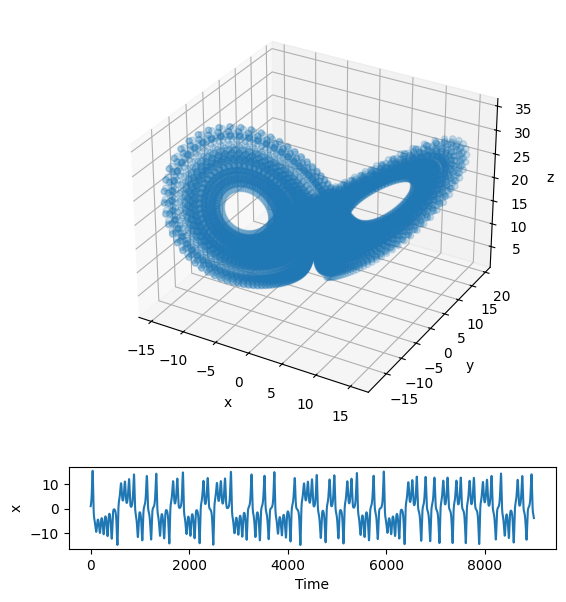

In [99]:
def A(x, sigma,rho,beta):
    # print(x)
    dxdt = sigma * (x[1] - x[0])
    dydt = rho*x[0] - x[0]*x[2] - x[1]
    dzdt = x[0]*x[1] - beta*x[2]

    # dxdt = x[1]
    # dydt = -x[0]

    return np.array([dxdt, dydt, dzdt])

x = [np.array([1,2,3])]

p = [10,20,8/3]

dt = 1e-2
epochs = 9000

for _ in range(epochs):
    dx = A(x[-1], *p) * dt
    x.append(x[-1] + dx)

x = np.stack(x, axis=0)

sequence = x[:,0]


fig = plt.figure(figsize=(5,7))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=(5,1))

ax = fig.add_subplot(gs[0], projection='3d')
ax.scatter(x[:,0], x[:,1], x[:,2], alpha=0.2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax = fig.add_subplot(gs[1])
ax.plot(np.arange(epochs+1), x[:,0])
ax.set_xlabel('Time')
ax.set_ylabel('x')

plt.subplots_adjust(right=1.1)




# Deep approaches

In [3]:
sequence = x[:,0]

X = sequence[:-1]
Y = sequence[1:]
L = 10


In [4]:
import torch

class PappoSet(torch.utils.data.Dataset): 
    def __init__(self, X, Y, L):
        self.X = torch.Tensor(X)  
        self.Y = torch.Tensor(Y)
        self.L = L

    def __len__(self):
        return self.Y.shape[0] - L
    
    def __getitem__(self, i):
        return self.X[i:i+L], self.Y[i+L] # Return the i-th sample

    def labels(self):
        return self.Y.detach().numpy()


In [5]:
split_idx = int(len(X)*0.8)
trainset = PappoSet(X[:split_idx],Y[:split_idx],L)
validset = PappoSet(X[split_idx:],Y[split_idx:],L)

In [6]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=64)

In [7]:
class PappoNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.linear = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.readout = torch.nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.relu(self.linear(x))
        return self.readout(x)


class PappoCNN(torch.nn.Module):
    def __init__(self, ks1, ks2, output_size):
        super().__init__()

        self.c1 = torch.nn.Conv1d(1,1,ks1, padding=1)
        self.c2 = torch.nn.Conv1d(1,1,ks2, padding=3)
        self.relu = torch.nn.ReLU()
        self.readout = torch.nn.Linear(10, output_size)
    
    def forward(self, x):
        x = x.unsqueeze(dim=1)
        x = self.relu(self.c1(x))
        x = self.relu(self.c2(x))
        return self.readout(x)



In [11]:
model = PappoNN(L, 50, 1)
# model = PappoCNN(3, 7, 1)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

Training Network...:   0%|          | 0/20 [00:00<?, ?epoch/s]/home/janko/.virtualenvs/rdn/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/janko/.virtualenvs/rdn/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/janko/.virtualenvs/rdn/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([42, 1])) that is different to the input size (torch.Size([42])). This will likel

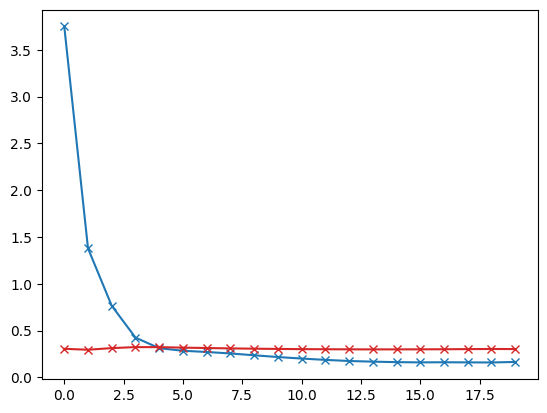

In [12]:
epochs = 20

trainlosses = np.zeros(epochs)
validlosses = np.zeros(epochs)

for _ in tqdm(range(epochs), desc="Training Network...", unit="epoch"):
    model.train()

    for X, Y in trainloader:
        Y_pred = model(X)
        loss = loss_fn(Y, Y_pred)
        
        opt.zero_grad()
        loss.backward()
        opt.step()

        trainloss = 0
        trainlosses[_] += loss.detach().numpy()/len(trainset)

    model.eval()
    for X, Y in validloader:
        Y_pred = model(X)
        loss = loss_fn(Y, Y_pred)

        validlosses[_] += loss.detach().numpy()/len(validset)


plt.plot(trainlosses, '-x', c='tab:blue')
plt.plot(validlosses, '-x', c='tab:red')

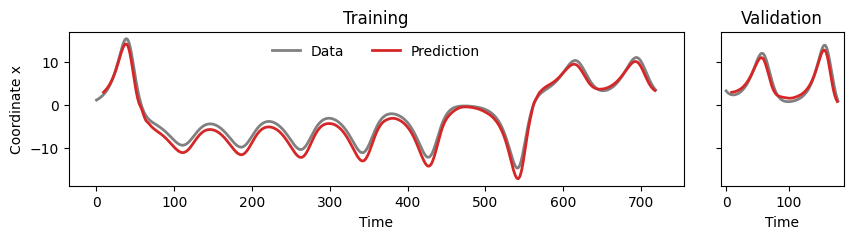

In [13]:
train_prediction = []
valid_prediction = []

for X, Y in trainloader:
    Y_pred = model(X)
    train_prediction.append(Y_pred.detach().numpy())

for X, Y in validloader:
    Y_pred = model(X)
    valid_prediction.append(Y_pred.detach().numpy())


train_prediction = np.concatenate(train_prediction).squeeze()
valid_prediction = np.concatenate(valid_prediction).squeeze()

fig, axs = plt.subplots(1,2, figsize=(10,2), sharey=True, width_ratios=(5,1))

ax = axs[0]
ax.plot(trainset.labels(), c='gray', linewidth=2, label='Data')
ax.plot(np.arange(len(train_prediction))+9, train_prediction, c='tab:red', linewidth=2, label='Prediction')
ax.legend(frameon=False, ncols=2)

ax.set_title('Training')
ax.set_xlabel('Time')
ax.set_ylabel('Coordinate x')

ax = axs[1]
ax.plot(validset.labels(), c='gray', linewidth=2)
ax.plot(np.arange(len(valid_prediction))+9, valid_prediction, c='tab:red', linewidth=2)

ax.set_title('Validation')
ax.set_xlabel('Time')

plt.subplots_adjust(wspace=0.1)

# Reservoir approach

In [171]:
class Reservoir:
    '''
    x_t = h(W x_t-1 + Q z_t + R)
    y_t = Ax_t + B
    '''
    def __init__(self, state_dim, input_dim):
        self.W = np.random.randn(state_dim, state_dim)
        self.Q = np.random.randn(state_dim, input_dim)
        self.R = np.random.randn(state_dim, 1)
        self.A = np.random.randn(input_dim, state_dim)
        self.B = np.random.randn(input_dim, 1)

        self.x = np.random.randn(state_dim, 1)


    def _nonlin(self, x):
        # return np.arctan(x)
        return np.where(x>0, x, 0)

    def step(self, z):
        self.x = self._nonlin(
            self.W @ self.x + self.Q * z + self.R
        )

    def read(self):
        return self.A @ self.x + self.B


reservoir = Reservoir(3, 1)
driving_idx = 8000


states = []
outs = np.empty_like(sequence[:driving_idx])

for idx, z in enumerate(sequence[:driving_idx]):
    reservoir.step(z)
    outs[idx] = reservoir.read()
    states.append(reservoir.x)

states = np.stack(states, axis=0).squeeze()


/tmp/ipykernel_2258/3557869596.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  outs[idx] = reservoir.read()


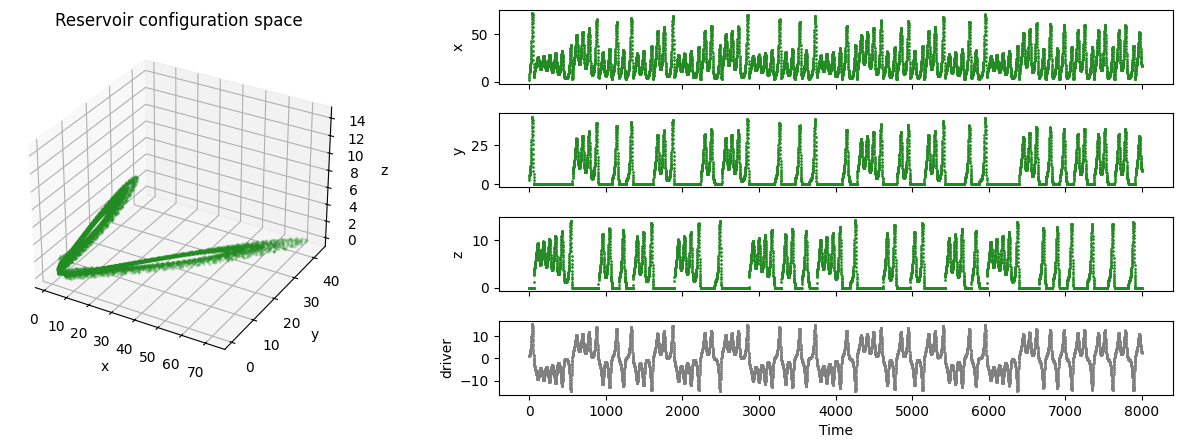

In [172]:
fig = plt.figure(figsize=(15,5))
gs = fig.add_gridspec(ncols=2, nrows=4, width_ratios=(1,2))

ax = fig.add_subplot(gs[:,0], projection='3d')
ax.scatter(states.T[0], states.T[1], states.T[2], alpha=0.2, c='Forestgreen', s=2)

ax.set_title('Reservoir configuration space')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

for i, lab in enumerate(['x','y','z']):
    ax = fig.add_subplot(gs[i,1])
    ax.scatter(np.arange(driving_idx), states.T[i], s=1, c='Forestgreen')
    ax.set_xticklabels('')
    ax.set_ylabel(lab)

ax = fig.add_subplot(gs[3,1])
ax.scatter(np.arange(driving_idx), sequence[:driving_idx], s=1, c='gray')
ax.set_xlabel('Time')
ax.set_ylabel('driver')

plt.subplots_adjust(hspace=0.4, wspace=0.3)
